# Project: Train a Quadcopter How to Fly

Design an agent that can fly a quadcopter, and then train it using a reinforcement learning algorithm of your choice! Try to apply the techniques you have learnt, but also feel free to come up with innovative ideas and test them.

![Quadcopter doing a flip trying to takeoff from the ground](images/quadcopter_tumble.png)

## Instructions

> **Note**: If you haven't done so already, follow the steps in this repo's README to install ROS, and ensure that the simulator is running and correctly connecting to ROS.

When you are ready to start coding, take a look at the `quad_controller_rl/src/` (source) directory to better understand the structure. Here are some of the salient items:

- `src/`: Contains all the source code for the project.
  - `quad_controller_rl/`: This is the root of the Python package you'll be working in.
  - ...
  - `tasks/`: Define your tasks (environments) in this sub-directory.
    - `__init__.py`: When you define a new task, you'll have to import it here.
    - `base_task.py`: Generic base class for all tasks, with documentation.
    - `takeoff.py`: This is the first task, already defined for you, and set to run by default.
  - ...
  - `agents/`: Develop your reinforcement learning agents here.
    - `__init__.py`: When you define a new agent, you'll have to import it here, just like tasks.
    - `base_agent.py`: Generic base class for all agents, with documentation.
    - `policy_search.py`: A sample agent has been provided here, and is set to run by default.
  - ...

### Tasks

Open up the base class for tasks, `BaseTask`, defined in `tasks/base_task.py`:

```python
class BaseTask:
    """Generic base class for reinforcement learning tasks."""

    def __init__(self):
        """Define state and action spaces, initialize other task parameters."""
        pass
    
    def set_agent(self, agent):
        """Set an agent to carry out this task; to be called from update."""
        self.agent = agent
    
    def reset(self):
        """Reset task and return initial condition."""
        raise NotImplementedError
    
    def update(self, timestamp, pose, angular_velocity, linear_acceleration):
        """Process current data, call agent, return action and done flag."""
        raise NotImplementedError            
```

All tasks must inherit from this class to function properly. You will need to override the `reset()` and `update()` methods when defining a task, otherwise you will get `NotImplementedError`'s. Besides these two, you should define the state (observation) space and the action space for the task in the constructor, `__init__()`, and initialize any other variables you may need to run the task.

Now compare this with the first concrete task `Takeoff`, defined in `tasks/takeoff.py`:

```python
class Takeoff(BaseTask):
    """Simple task where the goal is to lift off the ground and reach a target height."""
    ...
```

In `__init__()`, notice how the state and action spaces are defined using [OpenAI Gym spaces](https://gym.openai.com/docs/#spaces), like [`Box`](https://github.com/openai/gym/blob/master/gym/spaces/box.py). These objects provide a clean and powerful interface for agents to explore. For instance, they can inspect the dimensionality of a space (`shape`), ask for the limits (`high` and `low`), or even sample a bunch of observations using the `sample()` method, before beginning to interact with the environment. We also set a time limit (`max_duration`) for each episode here, and the height (`target_z`) that the quadcopter needs to reach for a successful takeoff.

The `reset()` method is meant to give you a chance to reset/initialize any variables you need in order to prepare for the next episode. You do not need to call it yourself; it will be invoked externally. And yes, it will be called once before each episode, including the very first one. Here `Takeoff` doesn't have any episode variables to initialize, but it must return a valid _initial condition_ for the task, which is a tuple consisting of a [`Pose`](http://docs.ros.org/api/geometry_msgs/html/msg/Pose.html) and [`Twist`](http://docs.ros.org/api/geometry_msgs/html/msg/Twist.html) object. These are ROS message types used to convey the pose (position, orientation) and velocity (linear, angular) you want the quadcopter to have at the beginning of an episode. You may choose to supply the same initial values every time, or change it a little bit, e.g. `Takeoff` drops the quadcopter off from a small height with a bit of randomness.

> **Tip**: Slightly randomized initial conditions can help the agent explore the state space faster.

Finally, the `update()` method is perhaps the most important. This is where you define the dynamics of the task and engage the agent. It is called by a ROS process periodically (roughly 30 times a second, by default), with current data from the simulation. A number of arguments are available: `timestamp` (you can use this to check for timeout, or compute velocities), `pose` (position, orientation of the quadcopter), `angular_velocity`, and `linear_acceleration`. You do not have to include all these variables in every task, e.g. `Takeoff` only uses pose information, and even that requires a 7-element state vector.

Once you have prepared the state you want to pass on to your agent, you will need to compute the reward, and check whether the episode is complete (e.g. agent crossed the time limit, or reached a certain height). Note that these two things (`reward` and `done`) are based on actions that the agent took in the past. When you are writing your own agents, you have to be mindful of this.

Now you can pass in the `state`, `reward` and `done` values to the agent's `step()` method and expect an action vector back that matches the action space that you have defined, in this case a `Box(6,)`. After checking that the action vector is non-empty, and clamping it to the space limits, you have to convert it into a ROS `Wrench` message. The first 3 elements of the action vector are interpreted as force in x, y, z directions, and the remaining 3 elements convey the torque to be applied around those axes, respectively.

Return the `Wrench` object (or `None` if you don't want to take any action) and the `done` flag from your `update()` method (note that when `done` is `True`, the `Wrench` object is ignored, so you can return `None` instead). This will be passed back to the simulation as a control command, and will affect the quadcopter's pose, orientation, velocity, etc. You will be able to gauge the effect when the `update()` method is called in the next time step.

### Agents

Reinforcement learning agents are defined in a similar way. Open up the generic agent class, `BaseAgent`, defined in `agents/base_agent.py`, and the sample agent `RandomPolicySearch` defined in `agents/policy_search.py`. They are actually even simpler to define - you only need to implement the `step()` method that is discussed above. It needs to consume `state` (vector), `reward` (scalar value) and `done` (boolean), and produce an `action` (vector). The state and action vectors must match the respective space indicated by the task. And that's it!

Well, that's just to get things working correctly! The sample agent given `RandomPolicySearch` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode ("score"), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

In [1]:
%%html
<div style="width: 100%; text-align: center;">
    <h3>Teach a Quadcopter How to Tumble</h3>
    <video poster="images/quadcopter_tumble.png" width="640" controls muted>
        <source src="images/quadcopter_tumble.mp4" type="video/mp4" />
        <p>Video: Quadcopter tumbling, trying to get off the ground</p>
    </video>
</div>

Obviously, this agent performs very poorly on the task. It does manage to move the quadcopter, which is good, but instead of a stable takeoff, it often leads to dizzying cartwheels and somersaults! And that's where you come in - your first _task_ is to design a better agent for this takeoff task. Instead of messing with the sample agent, create new file in the `agents/` directory, say `policy_gradients.py`, and define your own agent in it. Remember to inherit from the base agent class, e.g.:

```python
class DDPG(BaseAgent):
    ...
```

You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode_vars()`, etc.).

> **Note**: This setup may look similar to the common OpenAI Gym paradigm, but there is one small yet important difference. Instead of the agent calling a method on the environment (to execute an action and obtain the resulting state, reward and done value), here it is the task that is calling a method on the agent (`step()`). If you plan to store experience tuples for learning, you will need to cache the last state ($S_{t-1}$) and last action taken ($A_{t-1}$), then in the next time step when you get the new state ($S_t$) and reward ($R_t$), you can store them along with the `done` flag ($\left\langle S_{t-1}, A_{t-1}, R_t, S_t, \mathrm{done?}\right\rangle$).

When an episode ends, the agent receives one last call to the `step()` method with `done` set to `True` - this is your chance to perform any cleanup/reset/batch-learning (note that no reset method is called on an agent externally). The action returned on this last call is ignored, so you may safely return `None`. The next call would be the beginning of a new episode.

One last thing - in order to run your agent, you will have to edit `agents/__init__.py` and import your agent class in it, e.g.:

```python
from quad_controller_rl.agents.policy_gradients import DDPG
```

Then, while launching ROS, you will need to specify this class name on the commandline/terminal:

```bash
roslaunch quad_controller_rl rl_controller.launch agent:=DDPG
```

Okay, now the first task is cut out for you - follow the instructions below to implement an agent that learns to take off from the ground. For the remaining tasks, you get to define the tasks as well as the agents! Use the `Takeoff` task as a guide, and refer to the `BaseTask` docstrings for the different methods you need to override. Use some debug print statements to understand the flow of control better. And just like creating new agents, new tasks must inherit `BaseTask`, they need be imported into `tasks/__init__.py`, and specified on the commandline when running:

```bash
roslaunch quad_controller_rl rl_controller.launch task:=Hover agent:=DDPG
```

> **Tip**: You typically need to launch ROS and then run the simulator manually. But you can automate that process by either copying/symlinking your simulator to `quad_controller_rl/sim/DroneSim` (`DroneSim` must be an executable/link to one), or by specifying it on the command line, as follows:
> 
> ```bash
> roslaunch quad_controller_rl rl_controller.launch task:=Hover agent:=DDPG sim:=<full path>
> ```

## Task 1: Takeoff

### Implement takeoff agent

Train an agent to successfully lift off from the ground and reach a certain threshold height. Develop your agent in a file under `agents/` as described above, implementing at least the `step()` method, and any other supporting methods that might be necessary. You may use any reinforcement learning algorithm of your choice (note that the action space consists of continuous variables, so that may somewhat limit your choices).

The task has already been defined (in `tasks/takeoff.py`), which you should not edit. The default target height (Z-axis value) to reach is 10 units above the ground. And the reward function is essentially the negative absolute distance from that set point (upto some threshold). An episode ends when the quadcopter reaches the target height (x and y values, orientation, velocity, etc. are ignored), or when the maximum duration is crossed (5 seconds).  See `Takeoff.update()` for more details, including episode bonus/penalty.

As you develop your agent, it's important to keep an eye on how it's performing. Build in a mechanism to log/save the total rewards obtained in each episode to file. Once you are satisfied with your agent's performance, return to this notebook to plot episode rewards, and answer the questions below.

### Plot episode rewards

Plot the total rewards obtained in each episode, either from a single run, or averaged over multiple runs.

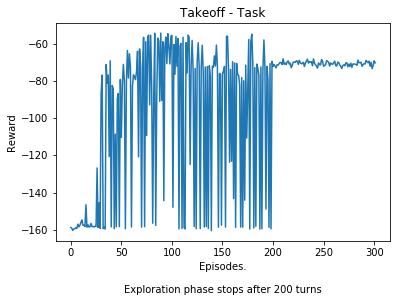

In [16]:
import pandas
import matplotlib
import matplotlib.pyplot as plt

def plot_learning(title, file_name):
    csv = pandas.read_csv(file_name)

    rewards = csv[['total_reward']].values

    fig, ax = plt.subplots()

    vals = csv.values
    episodes = [i for i in range(1, len(rewards))]

    ax.plot(rewards)
    ax.set_ylabel("Reward")
    ax.set_xlabel("Episodes.\n\nExploration phase stops after 200 turns")
    ax.set_title(title)

plot_learning("Takeoff - Task", "../out/takeoff.csv")

**Q**: What algorithm did you use? Briefly discuss why you chose it for this task.

**A**: I spent a lot of time (4 whole weekends) trying to get the originally proposed deep deterministic policy gradient  working stable for all 3 main tasks. It worked pretty well for the landing and takeoff task, but it did not converge as desired in the hovering case.

It became hovering more and more stable after limiting the action space to the z axis and the state space to the z position so the algorithm could concentrate on it's real task, but the result was not satisfying. The takeoff though worked pretty well. After it was offically allowed to also use DQN based techniques I found this awesome article:
https://keon.io/deep-q-learning/

It basically focuses on estimating the Q value and future Q value provided a given current state and like the originally proposed approach uses the replay buffer the learn in batches.

**Q**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**A**: The takeoff task became stable very fast, far faster than the hovering task for example in which the agent continually has to decide how much thrust is required right now. It learns very quickly "the more thrust the more reward".

It crashes into the ground very often in the first two dozen episodes until it often enough (through very intensive, high  exploration in the first episodes) experienced that much thrust in general also means much reward. 

I defined 16 thrust levels and it always converges as desired on the highest.


## Task 2: Hover

### Implement hover agent

Now, your agent must take off and hover at the specified set point (say, 10 units above the ground). Same as before, you will need to create an agent and implement the `step()` method (and any other supporting methods) to apply your reinforcement learning algorithm. You may use the same agent as before, if you think your implementation is robust, and try to train it on the new task. But then remember to store your previous model weights/parameters, in case your results were worth keeping.

### States and rewards

Even if you can use the same agent, you will need to create a new task, which will allow you to change the state representation you pass in, how you verify when the episode has ended (the quadcopter needs to hover for at least a few seconds), etc. In this hover task, you may want to pass in the target height as part of the state (otherwise how would the agent know where you want it to go?). You may also need to revisit how rewards are computed. You can do all this in a new task file, e.g. `tasks/hover.py` (remember to follow the steps outlined above to create a new task):

```python
class Hover(BaseTask):
    ...
```

**Q**: Did you change the state representation or reward function? If so, please explain below what worked best for you, and why you chose that scheme. Include short code snippet(s) if needed.

**A**: I once added the z velocity to the state set, but it turned out that completely concentrating on the pure, already normalized z level is more effective in the end.

I wrote a new reward ranking which takes care that the drone does not leave it's initial region at a height of 10. It gains huge reward within the range of 8 to 12 and in the validation episodes also showed as desired an instant decrease of thrust when it accidentally leaves it to above 12 to get back into the region.

### Implementation notes

**Q**: Discuss your implementation below briefly, using the following questions as a guide:

- What algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

A:

**Algorithm:**
As written in the prior part I tried to implement the hovering using a DDGP network first and then after many many hours and loosig many hairs switched to a DQN approach which learned this simply task by far faster. I used the same algorithm for all four tasks. The hovering becomes very stable after about 100, I let it learn for 200 episodes though.

**Hyperparameters:**
I chose a discount rate gamma of 0.8, a learning rate alpha of 0.001 and an initial exploration rate epsilon of 1 / 100%.
Also I defined an epsilon decay factor of 0.96, so the exploration rate is decreased by 4% per turn, which is applied after each episode and results in a stagnation of about 200 turns which turned out to be the time it needed to get a really stable hovering.
Also I defined a very small replay buffer of just 200 turns, so basically up to 10 episodes, which worked far better than a very large one. I think one of the reasons is the huge exploration rate which leads to more noise by very old replay memory entries.
I tried many different hyper parameter configurations, but targeting 200 episodes for learning and handling short sighted to the direct impact of a height change turned out to be most effective way.

**Network architecture:**
I used a very straight forward DQN network as presented here for the pole game example: 
https://keon.io/deep-q-learning/

It uses 32 nodes in two hidden layers, each using a relu activation function. The input is the single z level value and the final result is densed down to a set of 16 Q values for potential, discrete actions, each defining a different thrust level. At the end of each episode this network is then fitted to the the real Q values of the replay buffer.

### Plot episode rewards

As before, plot the episode rewards, either from a single run, or averaged over multiple runs. Comment on any changes in learning behavior.

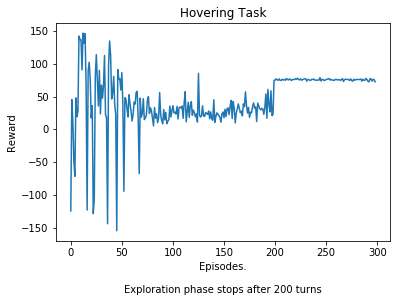

In [17]:
plot_learning("Hovering Task", "../out/hover.csv")

## Task 3: Landing

What goes up, must come down! But safely!

### Implement landing agent

This time, you will need to edit the starting state of the quadcopter to place it at a position above the ground (at least 10 units). And change the reward function to make the agent learn to settle down _gently_. Again, create a new task for this (e.g. `Landing` in `tasks/landing.py`), and implement the changes. Note that you will have to modify the `reset()` method to return a position in the air, perhaps with some upward velocity to mimic a recent takeoff.

Once you're satisfied with your task definition, create another agent or repurpose an existing one to learn this task. This might be a good chance to try out a different approach or algorithm.

### Initial condition, states and rewards

**Q**: How did you change the initial condition (starting state), state representation and/or reward function? Please explain below what worked best for you, and why you chose that scheme. Were you able to build in a reward mechanism for landing gently?

**A**: Yes. I calculated a desired position for each step in time by interpolating the two positions over the defined time axis of 5 seconds. The reward is then calculated by the distance to this optimum position. If the drone lands gently the reward will be maximized, if it lands too fast or too slow it will still get a positive reward, but a far lesser one as shown in the first episodes of the graph below.

### Implementation notes

**Q**: Discuss your implementation below briefly, using the same questions as before to guide you.

**A**: The technique used and the requirement of the dqn network for this task was very similar to the one of hovering task. The only actual difference was that this time the optimal z level is a moving target, slowly descending to the ground.

### Plot episode rewards

As before, plot the episode rewards, either from a single run, or averaged over multiple runs. This task is a little different from the previous ones, since you're starting in the air. Was it harder to learn? Why/why not?

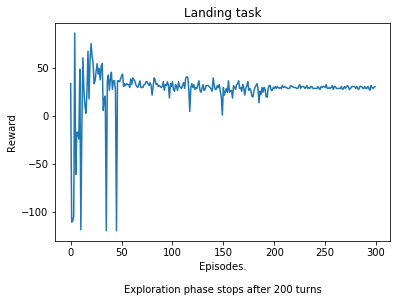

In [18]:
plot_learning("Landing task", "../out/land.csv")

## Task 4: Combined

In order to design a complete flying system, you will need to incorporate all these basic behaviors into a single agent.

### Setup end-to-end task

The end-to-end task we are considering here is simply to takeoff, hover in-place for some duration, and then land. Time to create another task! But think about how you might go about it. Should it be one meta-task that activates appropriate sub-tasks, one at a time? Or would a single combined task with something like waypoints be easier to implement? There is no right or wrong way here - experiment and find out what works best (and then come back to answer the following).

**Q**: What setup did you ultimately go with for this combined task? Explain briefly.

**A**: I stored the optimum weights on disk for each of the three task steps and "switched the drone's brain" for each individual sub task as a real remote control would likely do it as well in a similar way.

### Implement combined agent

Using your end-to-end task, implement the combined agent so that it learns to takeoff (at least 10 units above ground), hover (again, at least 10 units above ground), and gently come back to ground level.

### Combination scheme and implementation notes

Just like the task itself, it's up to you whether you want to train three separate (sub-)agents, or a single agent for the complete end-to-end task.

**Q**: What did you end up doing? What challenges did you face, and how did you resolve them? Discuss any other implementation notes below.

**A**: As mentioned above I combined the 3 previously learned modes. At the start of each round the drone starts at takeoff task conditions, switching to take off mode until it's target height is reached. Then it switches to hovering mode till second 10 and within the last 5 seconds gently comes back to the ground.

One interesting effect here was that in the standalone takeoff mode it did not hurt anybody if it took off very fast. In this combined scenario the follow up hovering task needs to successfully counter the velocity build up before, but it does it relative fine. As a result the landing task might hit the ground a bit earlier as intended and as result of it's stand alone training it may got up for 1 units or 2 again which maximized the reward in the standalone training mode when staying close to the estimated desired height at a given time.

### Plot episode rewards

As before, plot the episode rewards, either from a single run, or averaged over multiple runs.

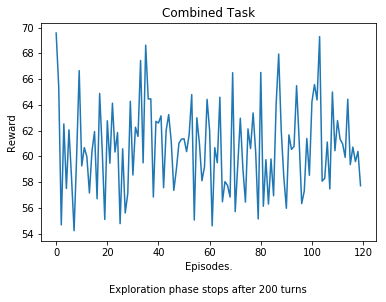

In [19]:
plot_learning("Combined Task", "../out/combined.csv")

## Reflections

**Q**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, running ROS, plotting, specific task, etc.)
- How did you approach each task and choose an appropriate algorithm/implementation for it?
- Did you find anything interesting in how the quadcopter or your agent behaved?

**A**:
I think the two hardest parts were getting a stable and connecting combination of ROS and the simulator on the one hand and the evil real-time waiting time on the other. I will likely still remember this project in many many years as an "experience". All other projects of this nanodegree were easily done in one day... this one easily took about 100 hours, no joke :). In the end I had to install ROS about 7 times on 4 different computer systems to get an acceptable combo of ROS and the simulator.

I unfortunately did not get the DDPG variant running with which I started, at least not the way I had wanted it in case of the hovering mode, but because the DDPG was so... "moody" I spent many many hours reading books of several algorithms, experimeting with lots of parameters, reading lots of blogs to find out which one of the common solutions meight help with my problem. I ended up with a DQN and am now very satisfied with the result, and in any case I collected lots of additional experience within the last weeks.

The definition of the tasks was in my opinion the easy part after the agent was finally able to successfully hover. I tried to keep the reward per step always in a range of -1 to 1 to accelerate the converging a bit. Then I tried to control the drone by rewarding "perfect" actions such as a very small difference to the hovering target very highly so that a randomly made experience through exploration will be remembered very quickly as well. This was also very clearly visible while training the takeoff. First it always crashed into the ground till it accidentally pressed the much thrust button a couple of times and you could instantly feel that it quickly tried that again and again.

One very interesting experience was that the DQN agent did not just blindly focus on any action in case of the hovering task. I imagined that if it starts quietly and finds out that keeping a thrust of like 20 will always keep it at level all other 15 available actions/thrust intensities meight loose importance completely. But they did not. In the combined task it detected very well, when the fast takeoff task "overshot" the desired height and countered it with many differnet thrust levels to "calm down" again.

Thank you very much for this 4 month experience!